In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses

In [2]:
print(tf.__version__)

2.9.2


In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84125825/84125825 [==============================] - 33s 0us/step


In [4]:
os.listdir(dataset_dir)

['imdbEr.txt', 'test', 'imdb.vocab', 'README', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['urls_unsup.txt',
 'neg',
 'urls_pos.txt',
 'unsup',
 'urls_neg.txt',
 'pos',
 'unsupBow.feat',
 'labeledBow.feat']

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
  'aclImdb/train',
  batch_size=batch_size,
  validation_split=0.2,
  subset='training',
  seed=seed
)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

2022-07-13 12:12:11.178058: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [13]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [14]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
  'aclImdb/train',
  batch_size=batch_size,
  validation_split=0.2,
  subset='validation',
  seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [15]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
  'aclImdb/test',
  batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


In [16]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(
    stripped_html,
    '[%s]' % re.escape(string.punctuation),
    ''
  )

In [47]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
  standardize=custom_standardization,
  max_tokens=max_features,
  output_mode='int',
  output_sequence_length=sequence_length
)

In [48]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [49]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [50]:
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print('Review', first_review)
print('Label', raw_train_ds.class_names[first_label])
print('Vectorization review', vectorize_text(first_review, first_label))

Review tf.Tensor(b"It's boggles the mind how this movie was nominated for seven Oscars and won one. Not because it's abysmal or because given the collective credentials of the creative team behind it really ought to deserve them but because in every category it was nominated Prizzi's Honor disappoints. Some would argue that old Hollywood pioneer John Huston had lost it by this point in his career but I don't buy it. Only the previous year he signed the superb UNDER THE VOLCANO, a dark character study set in Mexico, that ranks among the finest he ever did. Prizzi's Honor on the other hand, a film loaded with star power, good intentions and a decent script, proves to be a major letdown.<br /><br />The overall tone and plot of a gangster falling in love with a female hit-man prefigures the quirky crimedies that caught Hollywood by storm in the early 90's but the script is too convoluted for its own sake, the motivations are off and on the whole the story seems unsure of what exactly it's 

In [53]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 29 ---> ",vectorize_layer.get_vocabulary()[29])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 29 --->  its
Vocabulary size: 10000


In [54]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [55]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [56]:
embedding_dim = 16

In [57]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [59]:
model.compile(
  loss=losses.BinaryCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=tf.metrics.BinaryAccuracy(threshold=0.0)
)

In [60]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
625/625 [==============================] - 2s 2ms/step - loss: 0.6658 - binary_accuracy: 0.6891 - val_loss: 0.6172 - val_binary_accuracy: 0.7736
Epoch 2/10
625/625 [==============================] - 1s 2ms/step - loss: 0.5503 - binary_accuracy: 0.7985 - val_loss: 0.4993 - val_binary_accuracy: 0.8210
Epoch 3/10
625/625 [==============================] - 1s 2ms/step - loss: 0.4460 - binary_accuracy: 0.8431 - val_loss: 0.4206 - val_binary_accuracy: 0.8474
Epoch 4/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3788 - binary_accuracy: 0.8662 - val_loss: 0.3739 - val_binary_accuracy: 0.8604
Epoch 5/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3354 - binary_accuracy: 0.8788 - val_loss: 0.3451 - val_binary_accuracy: 0.8676
Epoch 6/10
625/625 [==============================] - 1s 2ms/step - loss: 0.3057 - binary_accuracy: 0.8889 - val_loss: 0.3262 - val_binary_accuracy: 0.8724
Epoch 7/10
625/625 [==============================] - 1s 2ms/ste

In [61]:
loss, accuracy = model.evaluate(test_ds)

print('Loss: ', loss)
print('Accuracy: ', accuracy)

157/157 [==============================] - 0s 440us/step - loss: 0.2923 - binary_accuracy: 0.8792
Loss:  0.2923336327075958
Accuracy:  0.8791999816894531


In [62]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

In [63]:
history_dict

{'loss': [0.6657860279083252,
  0.5502663850784302,
  0.44598183035850525,
  0.37877562642097473,
  0.3353872299194336,
  0.3056563436985016,
  0.2813510596752167,
  0.2624831199645996,
  0.2468308061361313,
  0.23198939859867096],
 'binary_accuracy': [0.6891499757766724,
  0.7985000014305115,
  0.8430500030517578,
  0.8662499785423279,
  0.8787500262260437,
  0.8888999819755554,
  0.8974499702453613,
  0.9036999940872192,
  0.9104499816894531,
  0.9167500138282776],
 'val_loss': [0.617223858833313,
  0.49926137924194336,
  0.4206358790397644,
  0.3738764524459839,
  0.3451347053050995,
  0.32618963718414307,
  0.31313419342041016,
  0.3036135137081146,
  0.296729177236557,
  0.2923336327075958],
 'val_binary_accuracy': [0.7735999822616577,
  0.8209999799728394,
  0.8474000096321106,
  0.8604000210762024,
  0.8676000237464905,
  0.8723999857902527,
  0.873199999332428,
  0.8755999803543091,
  0.876800000667572,
  0.8791999816894531]}

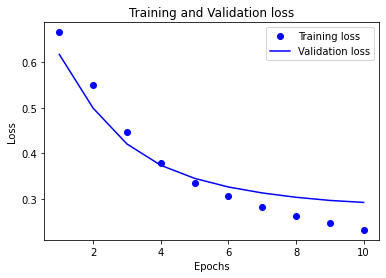

In [64]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

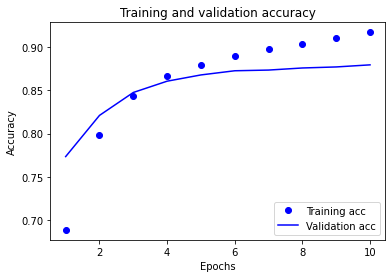

In [65]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [66]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
  loss=losses.BinaryCrossentropy(from_logits=False), # due to using sigmoid activation function
  optimizer='adam',
  metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 1s 2ms/step - loss: 0.3101 - accuracy: 0.8744
0.8744400143623352


In [70]:
examples = [
  'The movie was so so.',
  'The movie was fun.',
  'The movie was terrible.'
]

export_model.predict(examples)

1/1 [==============================] - 0s 17ms/step


array([[0.49577525],
       [0.61773294],
       [0.3648598 ]], dtype=float32)

# StackOverflow tag questions

In [74]:
import tarfile

tar = tarfile.open("stack_overflow_16k.tar.gz")
tar.extractall(path='./stack_overflow_16k')
tar.close()

In [75]:
os.listdir('stack_overflow_16k/')

['test', 'README.md', 'train']

In [76]:
model = 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          160016    
                                                                 
 dropout (Dropout)           (None, None, 16)          0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
__________________________________________________

In [81]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

os.makedirs('stack_overflow_16k')

train_path = os.path.join(os.path.dirname(dataset), 'train')
test_path = os.path.join(os.path.dirname(dataset), 'test')

shutil.move(train_path, os.path.join(os.path.dirname(dataset), 'stack_overflow_16k'))
shutil.move(test_path, os.path.join(os.path.dirname(dataset), 'stack_overflow_16k'))

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

6053168/6053168 [==============================] - 0s 0us/step


In [82]:
os.listdir(dataset_dir)

['test', 'train']

In [83]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['python', 'java', 'csharp', 'javascript']

In [84]:
sample_file = os.path.join(train_dir, 'python/1205.txt')
with open(sample_file) as f:
  print(f.read())

pretty graphics in blank i am trying to write a trading strategy summarizer.  the goal is to get something that looks like:....i can do the blank to calculate the values but any thoughts on how to replicate the graphics especially the table.



In [85]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
  'stack_overflow_16k/train/',
  batch_size=batch_size,
  validation_split=0.2,
  subset='training',
  seed=seed
)

Found 8000 files belonging to 4 classes.
Using 6400 files for training.


In [86]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print('Review', text_batch.numpy()[i])
    print('Label', label_batch.numpy()[i])

Review b'"my tester is going to the wrong constructor i am new to programming so if i ask a question that can be easily fixed, please forgive me. my program has a tester class with a main. when i send that to my regularpolygon class, it sends it to the wrong constructor. i have two constructors. 1 without perameters..public regularpolygon().    {.       mynumsides = 5;.       mysidelength = 30;.    }//end default constructor...and my second, with perameters. ..public regularpolygon(int numsides, double sidelength).    {.        mynumsides = numsides;.        mysidelength = sidelength;.    }// end constructor...in my tester class i have these two lines:..regularpolygon shape = new regularpolygon(numsides, sidelength);.        shape.menu();...numsides and sidelength were declared and initialized earlier in the testing class...so what i want to happen, is the tester class sends numsides and sidelength to the second constructor and use it in that class. but it only uses the default constru

In [88]:
print('Label 0 corresponds to', raw_train_ds.class_names[0])
print('Label 1 corresponds to', raw_train_ds.class_names[1])
print('Label 2 corresponds to', raw_train_ds.class_names[2])
print('Label 3 corresponds to', raw_train_ds.class_names[3])

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


In [89]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']

In [90]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
  'stack_overflow_16k/train',
  batch_size=batch_size,
  validation_split=0.2,
  subset='validation',
  seed=seed
)

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


In [91]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
  'stack_overflow_16k/test/',
  batch_size=batch_size
)

Found 8000 files belonging to 4 classes.


In [92]:
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

In [94]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

In [95]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [96]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4)
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 16)          160016    
                                                                 
 dropout_2 (Dropout)         (None, None, 16)          0         
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 160,084
Trainable params: 160,084
Non-trainable params: 0
________________________________________________

In [99]:
model.compile(
  loss=losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [100]:
epochs = 10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
200/200 [==============================] - 1s 2ms/step - loss: 1.3804 - accuracy: 0.3327 - val_loss: 1.3726 - val_accuracy: 0.3913
Epoch 2/10
200/200 [==============================] - 0s 2ms/step - loss: 1.3578 - accuracy: 0.4481 - val_loss: 1.3415 - val_accuracy: 0.5362
Epoch 3/10
200/200 [==============================] - 0s 2ms/step - loss: 1.3119 - accuracy: 0.5430 - val_loss: 1.2868 - val_accuracy: 0.5756
Epoch 4/10
200/200 [==============================] - 0s 2ms/step - loss: 1.2456 - accuracy: 0.6044 - val_loss: 1.2171 - val_accuracy: 0.6294
Epoch 5/10
200/200 [==============================] - 0s 2ms/step - loss: 1.1683 - accuracy: 0.6463 - val_loss: 1.1403 - val_accuracy: 0.6825
Epoch 6/10
200/200 [==============================] - 0s 2ms/step - loss: 1.0871 - accuracy: 0.6920 - val_loss: 1.0641 - val_accuracy: 0.7106
Epoch 7/10
200/200 [==============================] - 0s 2ms/step - loss: 1.0124 - accuracy: 0.7255 - val_loss: 0.9947 - val_accuracy: 0.7331
Epoch 

In [101]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 [==============================] - 0s 1ms/step - loss: 0.8641 - accuracy: 0.7416
Loss:  0.8641260862350464
Accuracy:  0.7416250109672546


In [102]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

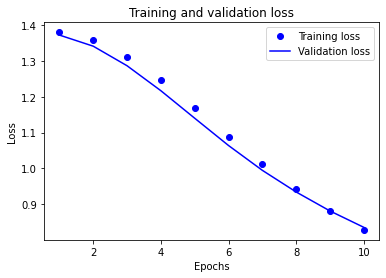

In [104]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

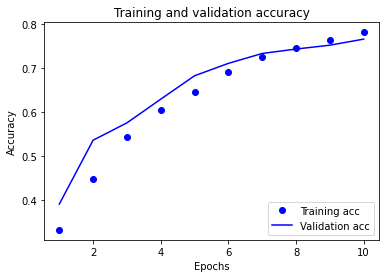

In [106]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In [116]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('softmax')
])

export_model.compile(
  loss=losses.SparseCategoricalCrossentropy(from_logits=False),
  optimizer='adam',
  metrics=['accuracy']
)

loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

250/250 [==============================] - 0s 1ms/step - loss: 0.8641 - accuracy: 0.7416
0.7416250109672546


In [158]:
examples = [
  "Let's say I have two lists a = [1, 2, 3] and b = [4, 5, 6]. How to get all elements in a that is in b?",
  
  "How can I sort a dictionary by value in Python?",
  
  'What is nodejs and why it is so popular?',
  
  """
  public class MyCollection : IDisposable
  {
      private List<String> _theList = new List<String>();
      private Dictionary<String, Point> _theDict = new Dictionary<String, Point>();

      // Die, clear it up! (free unmanaged resources)
      public void Dispose()
      {
          _theList.clear();
          _theDict.clear();
          _theList = null;
          _theDict = null;
      }
  }
  """,
  
  'Is React a good choice for learning front-end web dev?',
  
  """
  import tensorflow as tf
  import numpy as np
  """
]

In [159]:
export_model.predict(examples)

1/1 [==============================] - 0s 19ms/step


array([[0.24066474, 0.1961559 , 0.22319119, 0.33998814],
       [0.27318233, 0.20986715, 0.2858619 , 0.2310886 ],
       [0.26020393, 0.22384383, 0.3083684 , 0.20758377],
       [0.43063536, 0.35014835, 0.15326631, 0.06595004],
       [0.25000367, 0.21465358, 0.31239897, 0.22294384],
       [0.22615424, 0.1975801 , 0.25904906, 0.31721658]], dtype=float32)

In [160]:
for prediction in export_model.predict(examples):
  print(raw_train_ds.class_names[tf.argmax(prediction)])

1/1 [==============================] - 0s 18ms/step
python
javascript
javascript
csharp
javascript
python


In [161]:
raw_train_ds.class_names

['csharp', 'java', 'javascript', 'python']